In [ ]:
# Ashley Mayo
# DSC630: Predictive Analytics
# Final Project Code
# February 26th, 2025

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Load the uploaded dataset
file_path = './creditcard.csv'
df = pd.read_csv(file_path)

# Stratified Sampling
df_fraud = df[df["Class"] == 1]
df_legit = df[df["Class"] == 0].sample(n=len(df_fraud) * 5, random_state=42)
df_sampled = pd.concat([df_fraud, df_legit]).sample(frac=1, random_state=42)

# Prepare features and target variable
X = df.drop(columns=["Class", "Time"])  # Drop "Time" as it may not be useful
y = df["Class"]

In [3]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (excluding target variable)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest model with class balancing
model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Set a consistent style for all plots
sns.set_style("whitegrid")

In [4]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

Random Forest - Precision: 0.8267, Recall: 0.6327, F1: 0.7168, ROC-AUC: 0.8162


In [20]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train LightGBM with better hyperparameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,  # Increase number of trees
    max_depth=10,  # Allow deeper trees for better fraud detection
    learning_rate=0.01,  # Reduce learning rate for better accuracy
    class_weight="balanced",  # Adjust for class imbalance
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# Evaluate both models
models = {"Random Forest": rf_pred, "LightGBM": lgb_pred}
model_performance = []

for model_name, y_pred in models.items():
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    model_performance.append([model_name, precision, recall, f1, roc_auc])

# Convert to DataFrame for visualization
model_performance_df = pd.DataFrame(model_performance, columns=["Model", "Precision", "Recall", "F1-Score", "ROC-AUC"])

# Print the Model Performance Table
print("\n📊 Model Performance Comparison:")
print(model_performance_df.to_string(index=False))

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

📊 Model Performance Comparison:
        Model  Precision   Recall  F1-Score  ROC-AUC
Random Forest   0.912500 0.744898  0.820225 0.872387
     LightGBM   0.453125 0.887755  0.600000 0.942954


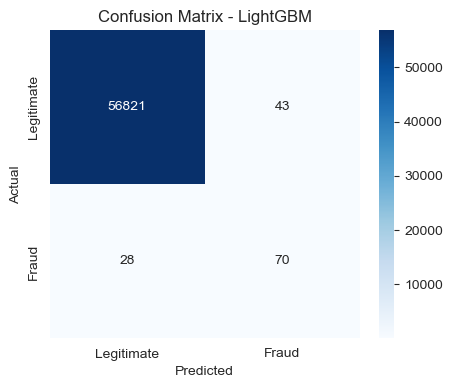

In [8]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, lgb_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")
plt.show()

C:\Users\ashle\AppData\Local\Temp\ipykernel_15656\3090990214.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_importance.index, x=feature_importance.values, orient="h", palette="viridis")


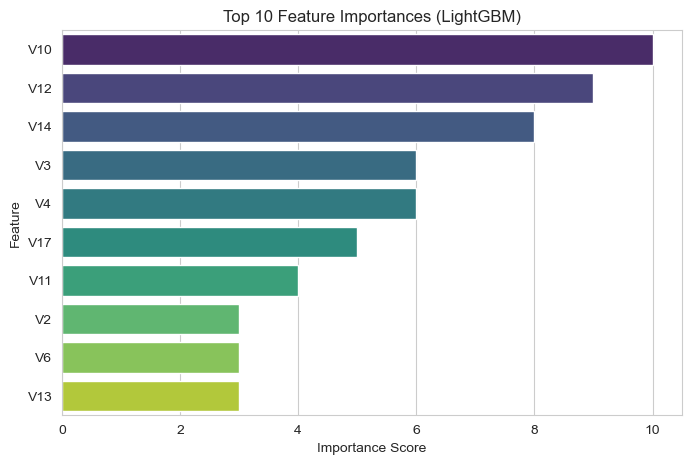

In [9]:
# Feature Importance Plot (LightGBM)
feature_importance = pd.Series(lgb_model.feature_importances_, index=X.columns).nlargest(10)
plt.figure(figsize=(8, 5))
sns.barplot(y=feature_importance.index, x=feature_importance.values, orient="h", palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (LightGBM)")
plt.show()

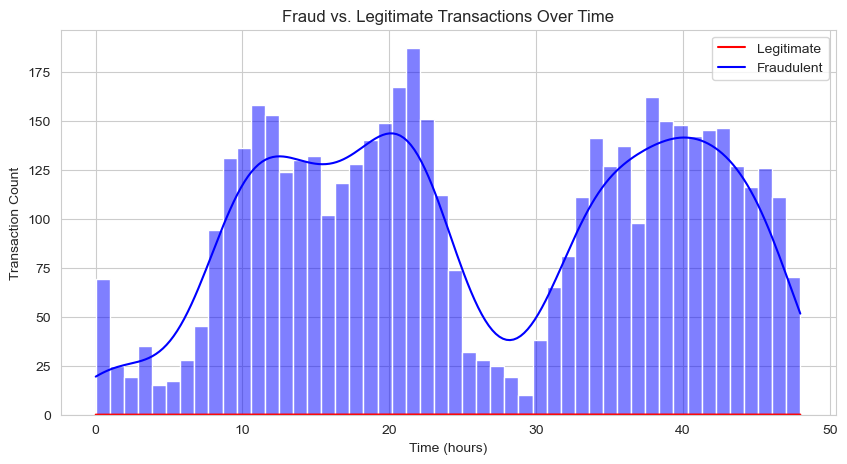

In [22]:
# Histogram of Fraud vs. Legitimate Transactions Over Time (for Slide 5)
df_sampled = df.sample(n=5000, random_state=42)  # Use a smaller subset for visualization
df_sampled["Time"] = df_sampled["Time"] / 3600  # Convert time to hours

plt.figure(figsize=(10, 5))
sns.histplot(data=df_sampled, x="Time", hue="Class", bins=50, kde=True, palette={0: "blue", 1: "red"})
plt.xlabel("Time (hours)")
plt.ylabel("Transaction Count")
plt.title("Fraud vs. Legitimate Transactions Over Time")
plt.legend(["Legitimate", "Fraudulent"])
plt.show()

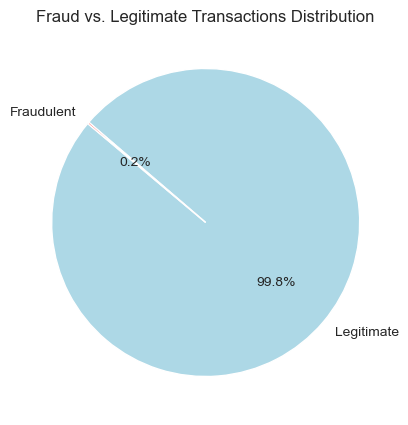

In [10]:
# Fraud vs. Legitimate Transactions Distribution
fraud_counts = df["Class"].value_counts()
fraud_labels = ["Legitimate", "Fraudulent"]

plt.figure(figsize=(5, 5))
plt.pie(fraud_counts, labels=fraud_labels, autopct="%1.1f%%", colors=["lightblue", "red"], startangle=140)
plt.title("Fraud vs. Legitimate Transactions Distribution")
plt.show()

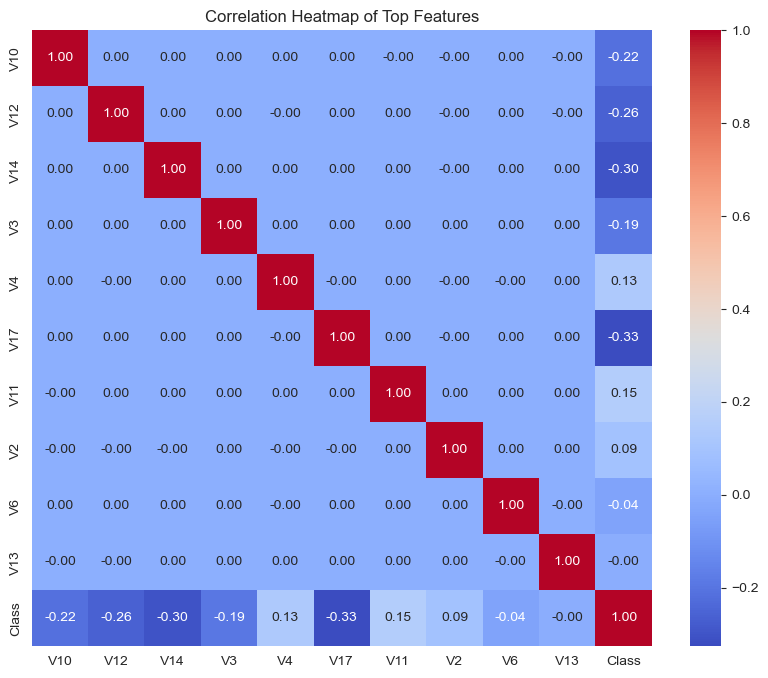

In [14]:
# 3. Correlation Heatmap of Top Features
top_features = feature_importance.index.tolist()  # Get top 10 most important features
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features + ["Class"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Features")
plt.show()

C:\Users\ashle\AppData\Local\Temp\ipykernel_15656\774724713.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y=top_features[0], data=df_sampled, palette="coolwarm")  # Use built-in palette


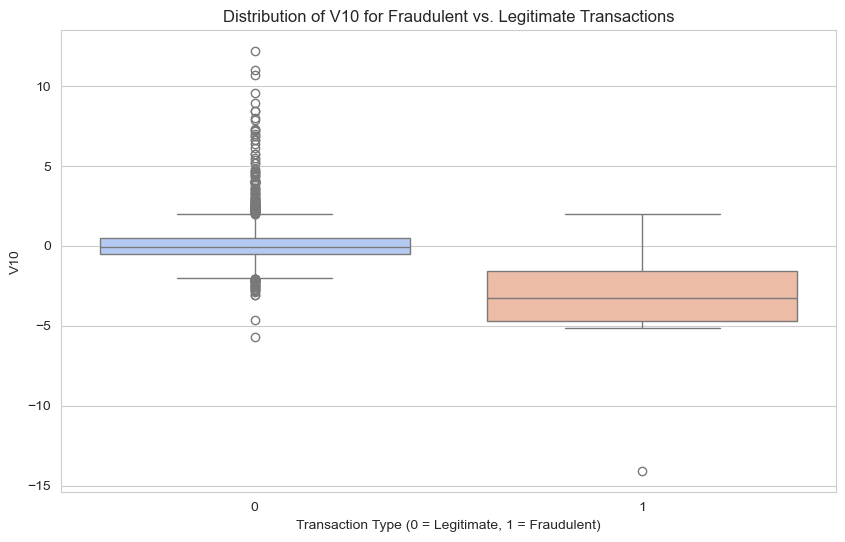

In [16]:
# Boxplot of High-Impact Features by Class (Fixed)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Class", y=top_features[0], data=df_sampled, palette="coolwarm")  # Use built-in palette
plt.xlabel("Transaction Type (0 = Legitimate, 1 = Fraudulent)")
plt.ylabel(top_features[0])
plt.title(f"Distribution of {top_features[0]} for Fraudulent vs. Legitimate Transactions")
plt.show()